# Computing Expected Improvement with a Parametric Mean Field Assumption
## What I Need to Do
- [ ] Check the sensitivity of the linear systems formed when solving for log likelihood of hybrid model

## Questions
- It still isn't clear to me how we compute the log determinant of our KKT-like system. In the limiting case of the uninformative prior, we have block zero entries in our linear system which seem to push the determinant to 0. 

In [1]:
using Profile
using ProfileView
using Polynomials

All the necessary imports for our computations of interest

In [2]:
include("../bayesian_optimization.jl")
plotlyjs()

WebIO._IJuliaInit()

┌ Warning: backend `PlotlyJS` is not installed.
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/backends.jl:45


Plots.PlotlyJSBackend()

## Basic Setup

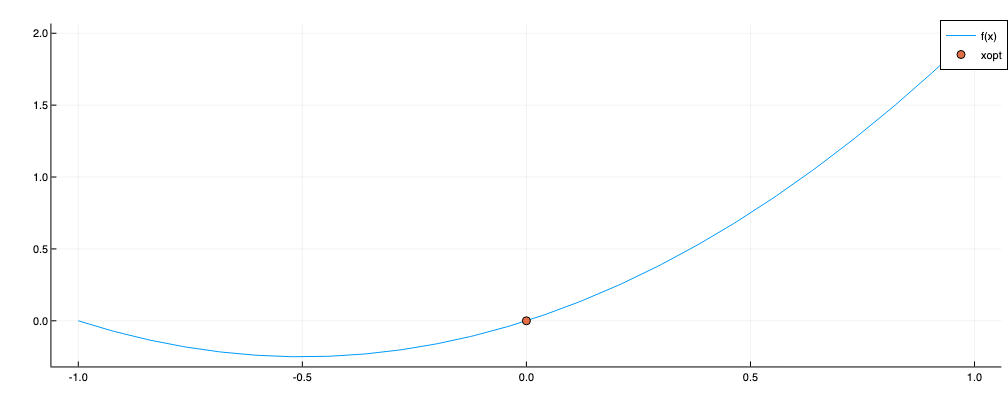

In [7]:
# Visualize 1D test function
polynomial = PolynomialBasisFunction([
        x -> 0., x -> first(x),
])
polynomial_trend = PolynomialTrend(polynomial, [1., 1.])
testfn = TestQuadratic1D() + polynomial_trend
# testfn = TestQuadratic1D()
# testfn = TestRosenbrock()
tplot(testfn)

In [7]:
lbs, ubs = get_bounds(testfn)
domain = lbs[1]:.01:ubs[1]

-1.0:0.01:1.0

In [8]:
kernel = SquaredExponential()
polynomial = PolynomialBasisFunction([
        x -> 1., x -> first(x) ^ 2,
])
N = 5
observation_noise = 1e-1
X = randsample(N, testfn.dim, lbs, ubs)
y = testfn(X) + observation_noise * randn(N)

hsur = HybridSurrogate(kernel, polynomial, X, y, decision_rule=EI(),
    observation_noise=observation_noise, capacity=N)
sur = Surrogate(kernel, X, y, decision_rule=EI(),
    observation_noise=observation_noise, capacity=N);

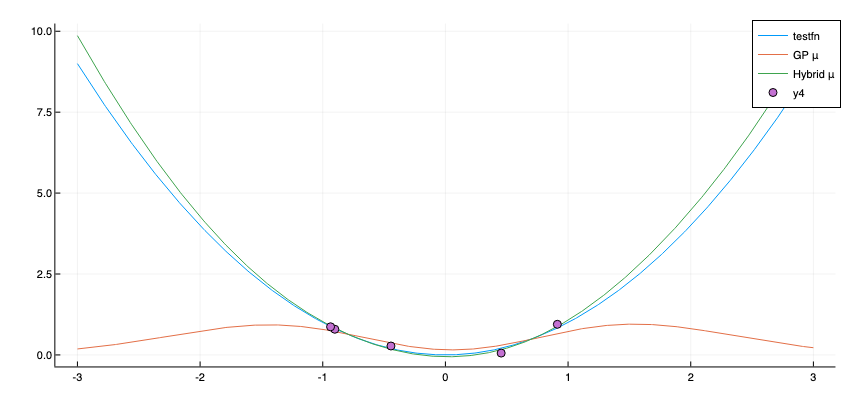

In [26]:
domain = 3. * lbs[1]:.01:3. * ubs[1]
μ = similar(domain) # Predictive mean for standard model: f(x) ~ Z(x)
μ2 = similar(domain) # Predictive mean for the hybrid model: f(x) ~ P(x)c + Z(x)
∇μ2 = similar(domain)
Hμ2 = similar(domain)
σ = similar(domain)
σ2 = similar(domain)
∇σ2 = similar(domain)
Hσ2 = similar(domain)
EIx = similar(domain)
EIx2 = similar(domain)

for (i, x) in enumerate(domain)
    sx = sur([x], [0.])
    hsx = hsur([x], [0.])
    
    μ[i] = sx.μ
    μ2[i] = hsx.μ
    ∇μ2[i] = first(hsx.∇μ)
    Hμ2[i] = first(hsx.Hμ)
    σ[i] = sx.σ
    σ2[i] = hsx.σ
    ∇σ2[i] = first(hsx.∇σ)
    Hσ2[i] = first(hsx.Hσ)
    EIx[i] = eval(sx)
    EIx2[i] = eval(hsx)
end

plot(domain, [testfn([x]) for x in domain], label="testfn")
# plot!(domain, μ, ribbons=2σ, label="GP μ")
plot!(domain, μ, label="GP μ")
# plot!(domain, μ2, ribbons=2σ2, label="Hybrid μ")
plot!(domain, μ2, label="Hybrid μ")
scatter!(get_active_covariates(hsur)', get_active_observations(sur))

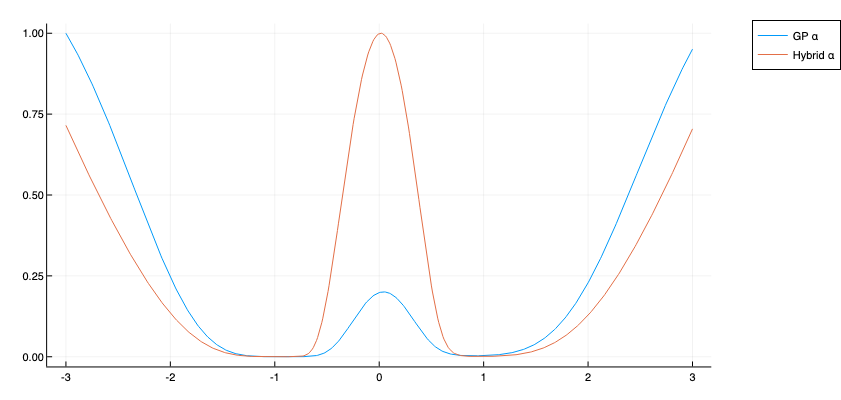

In [28]:
plot(domain, stdize(EIx), label="GP α")
plot!(domain, stdize(EIx2), label="Hybrid α", legend=:outertopright)
# plot!(domain, stdize(POIx), label="Probability of Improvement")
# plot!(domain, stdize(LCBx), label="Lower Confidence Bound")

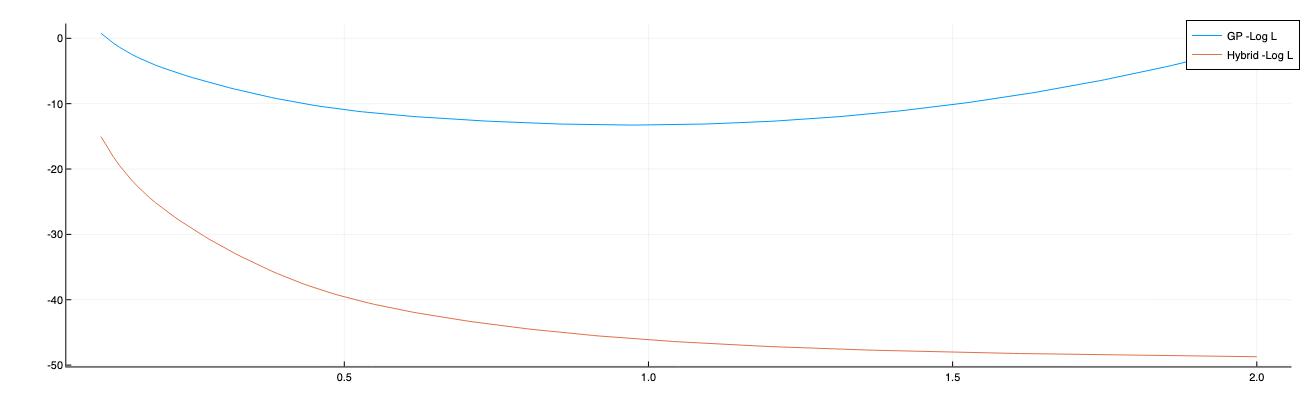

In [259]:
hyperparameter_grid = .1:.01:2.
results = similar(hyperparameter_grid)
grad_results = similar(hyperparameter_grid)
results_hybrid = similar(hyperparameter_grid)
grad_results_hybrid = similar(hyperparameter_grid)

for (i, hyperparameter) in enumerate(hyperparameter_grid)
    set_kernel!(
        sur,
        set_hyperparameters!(
            get_kernel(sur),
            [hyperparameter]
        )
    )
    set_kernel!(
        hsur,
        set_hyperparameters!(
            get_kernel(hsur),
            [hyperparameter]
        )
    )
    results_hybrid[i] = log_likelihood(hsur)
    grad_results_hybrid[i] = first(∇log_likelihood(hsur))
    results[i] = log_likelihood(sur)
    grad_results[i] = first(∇log_likelihood(sur))
end

plot(hyperparameter_grid, -results, label="GP -Log L")
plot!(hyperparameter_grid, -results_hybrid, label="Hybrid -Log L")

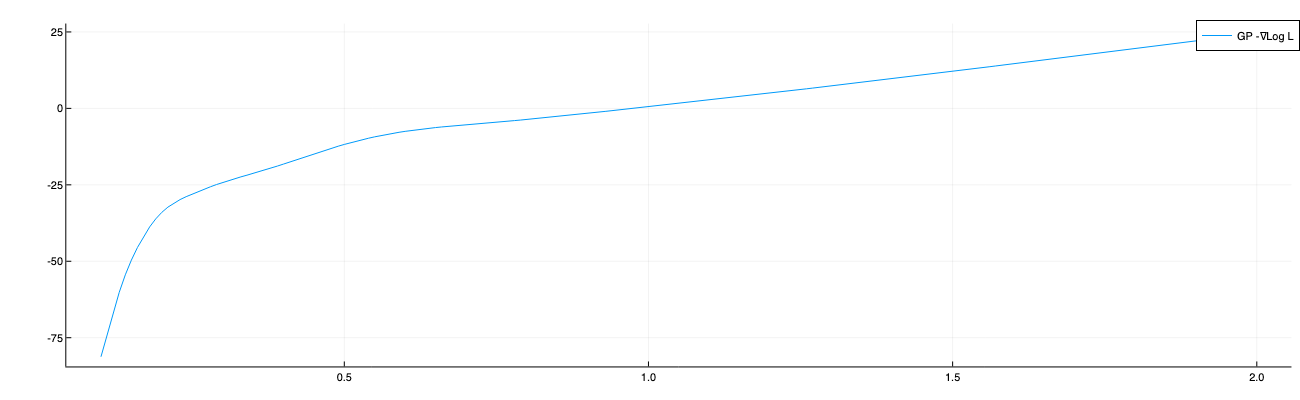

In [260]:
plot(hyperparameter_grid, -grad_results, label="GP -∇Log L")

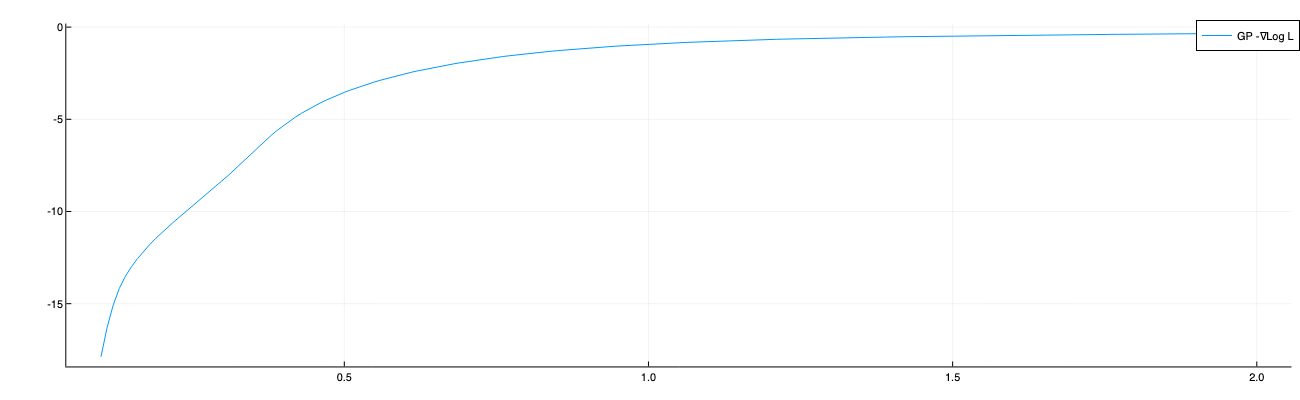

In [261]:
plot(hyperparameter_grid, -grad_results_hybrid, label="GP -∇Log L")